# Algorithmic Trading

In [211]:
#https://medium.com/@mrconnor/harnessing-deep-reinforcement-learning-for-algorithmic-trading-d80c36ceda6e

In [212]:
!pip install yfinance
!pip install ta
!pip install stable.baselines3
!pip3 install torch torchvision torchaudio

!pip install -U gym
!pip install 'shimmy>=0.2.1'

ERROR: Invalid requirement: "'shimmy"


In [213]:
import gym
from gym.utils import seeding
from gym import spaces

#!pip install TA-Lib
import warnings
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ta
import os
#import talib
warnings.filterwarnings("ignore")
# Optional Plotly Method Imports
import plotly
import cufflinks as cf
cf.go_offline()
from stable_baselines3 import A2C, PPO, DDPG
from stable_baselines3.common.policies import ActorCriticPolicy #MlpPolicy for A2C and PPO
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import ActionNoise, OrnsteinUhlenbeckActionNoise

from datetime import date
from datetime import datetime

sns.set_style('whitegrid')
%matplotlib inline

In [214]:
#Tech Stocks
tic = ['GOOGL', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'META', 'NFLX', 'AMD',
       'NVDA', 'SMCI']

In [215]:
todays_date = datetime.now().strftime("%Y-%m-%d")
todays_date

'2024-03-06'

In [216]:
stock_data = pd.DataFrame()
stock_start_date = '2009-01-01'
stock_end_date = todays_date

In [217]:
for s in tic:

  temp_data = yfinance.download(s, start= stock_start_date, end=stock_end_date)
  temp_data['Ticker'] = s

  stock_data = stock_data.append(temp_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [218]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2009-01-02,7.722723,8.053554,7.645145,8.041041,8.041041,144275580,GOOGL
2009-01-05,8.033033,8.289289,7.882883,8.209459,8.209459,195364440,GOOGL
2009-01-06,8.332833,8.528529,8.167918,8.359860,8.359860,256750992,GOOGL
2009-01-07,8.216216,8.281031,7.976727,8.058308,8.058308,179600220,GOOGL
2009-01-08,7.964965,8.137888,7.941441,8.137888,8.137888,143883972,GOOGL


In [219]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2024-02-28,820.000000,846.50000,812.000000,816.539978,816.539978,6032500,SMCI
2024-02-29,839.000000,890.52002,839.000000,866.119995,866.119995,8842900,SMCI
2024-03-01,881.880005,927.00000,881.000000,905.479980,905.479980,9887600,SMCI
2024-03-04,1039.000000,1155.00000,1020.340027,1074.339966,1074.339966,20162100,SMCI
2024-03-05,1035.000000,1097.50000,976.099976,1090.829956,1090.829956,13304400,SMCI


In [220]:
stock_data.Ticker.unique()

array(['GOOGL', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'META', 'NFLX', 'AMD',
       'NVDA', 'SMCI'], dtype=object)

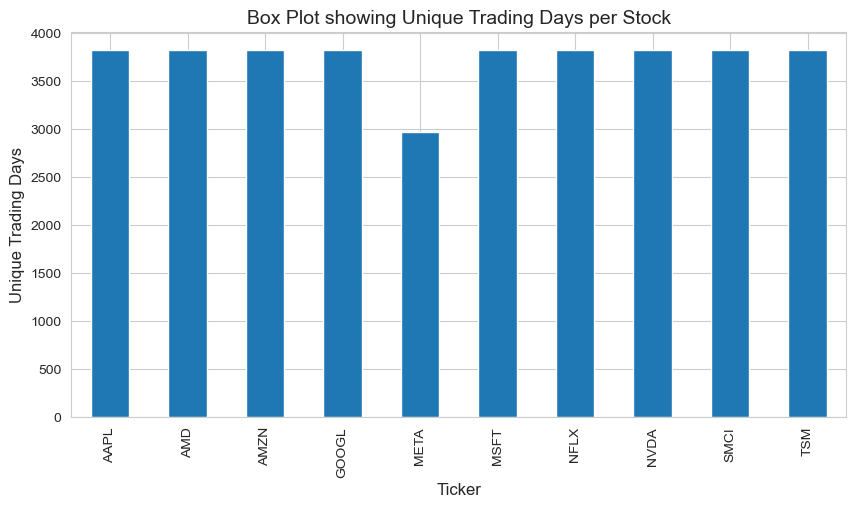

In [221]:
plt.figure(figsize=(10,5))
stock_data.groupby(by= 'Ticker').count()['Open'].plot(kind = 'bar')
plt.xlabel('Ticker', fontsize = 12)
plt.ylabel('Unique Trading Days', fontsize = 12)
plt.title('Box Plot showing Unique Trading Days per Stock', fontsize = 14)
plt.show()

In [222]:
df = stock_data.copy()
df.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2009-01-02,7.722723,8.053554,7.645145,8.041041,8.041041,144275580,GOOGL
2009-01-05,8.033033,8.289289,7.882883,8.209459,8.209459,195364440,GOOGL
2009-01-06,8.332833,8.528529,8.167918,8.359860,8.359860,256750992,GOOGL
2009-01-07,8.216216,8.281031,7.976727,8.058308,8.058308,179600220,GOOGL
2009-01-08,7.964965,8.137888,7.941441,8.137888,8.137888,143883972,GOOGL


In [223]:
#EDA
df = stock_data.copy()
# Dropping Closing Price Column
df = df.drop('Close', 1)
df = df.drop('Open', 1)
df = df.drop('High', 1)
df = df.drop('Low', 1)
df = df.drop('Volume', 1)

df.head()

,Adj Close,Ticker
Date,,
2009-01-02,8.041041,GOOGL
2009-01-05,8.209459,GOOGL
2009-01-06,8.359860,GOOGL
2009-01-07,8.058308,GOOGL
2009-01-08,8.137888,GOOGL


In [224]:
#Remanimg Adj Close
df = df.rename(columns={'Adj Close':'AdjClose'})
df = df.sort_values(by= ['Date', 'Ticker'])
df = df.reset_index()
df = df.pivot(index= 'Date', columns= 'Ticker')
df = df.droplevel(0, axis=1)
df = df.fillna(0)

df.head()

Ticker,AAPL,AMD,AMZN,GOOGL,META,MSFT,NFLX,NVDA,SMCI,TSM
Date,,,,,,,,,,
2009-01-02,2.743889,2.38,2.718,8.041041,0.0,15.038722,4.267143,1.997425,6.41,5.023496
2009-01-05,2.859692,2.67,2.703,8.209459,0.0,15.179271,4.562857,2.034118,7.06,4.925714
2009-01-06,2.812525,2.78,2.868,8.359860,0.0,15.356802,4.705714,2.102915,6.32,5.133499
2009-01-07,2.751750,2.66,2.810,8.058308,0.0,14.432138,4.672857,1.976786,6.25,4.711818
2009-01-08,2.802849,2.74,2.858,8.137888,0.0,14.883376,4.735714,1.926335,6.54,4.607928


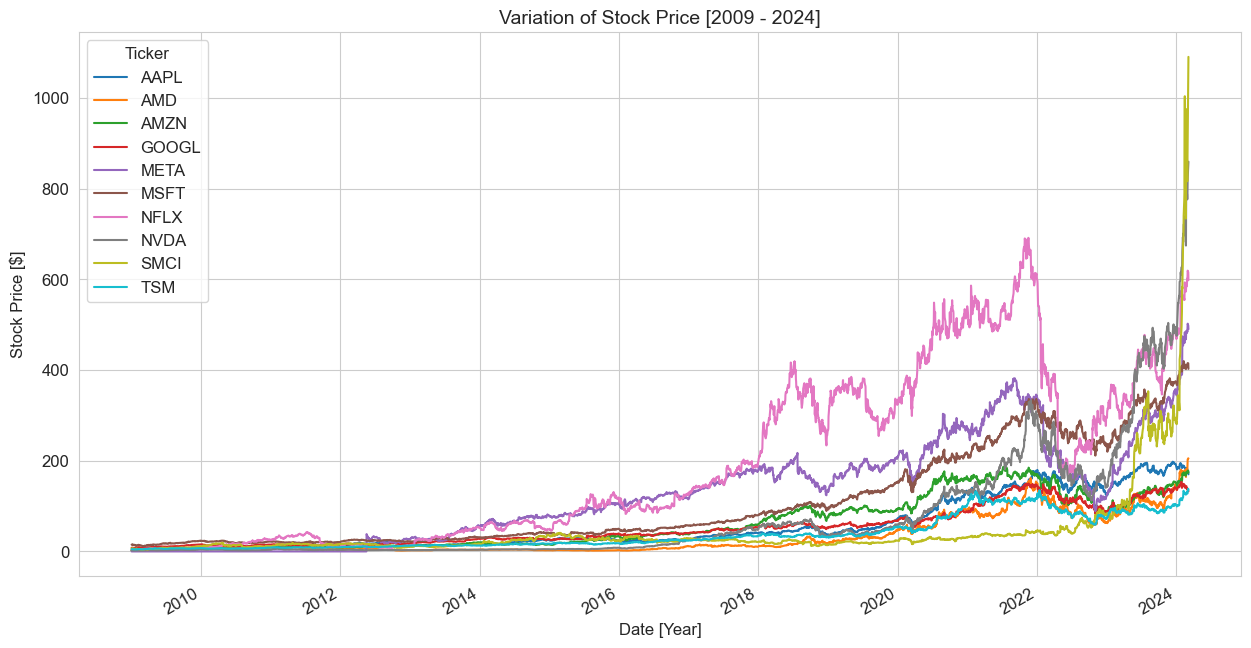

In [225]:
df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Stock Price [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12,title = 'Ticker', title_fontsize = '12')
plt.title('Variation of Stock Price [2009 - 2024]', fontsize = 14)
plt.show()

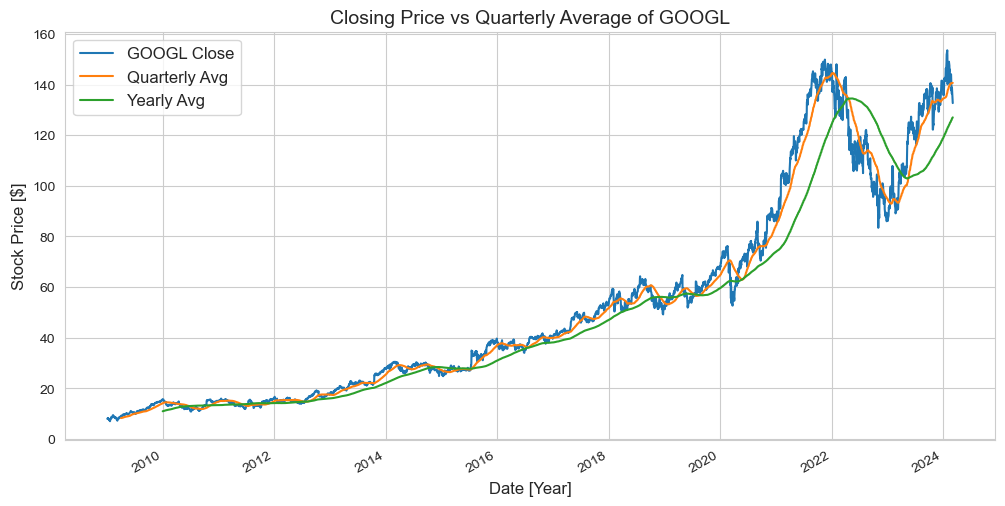

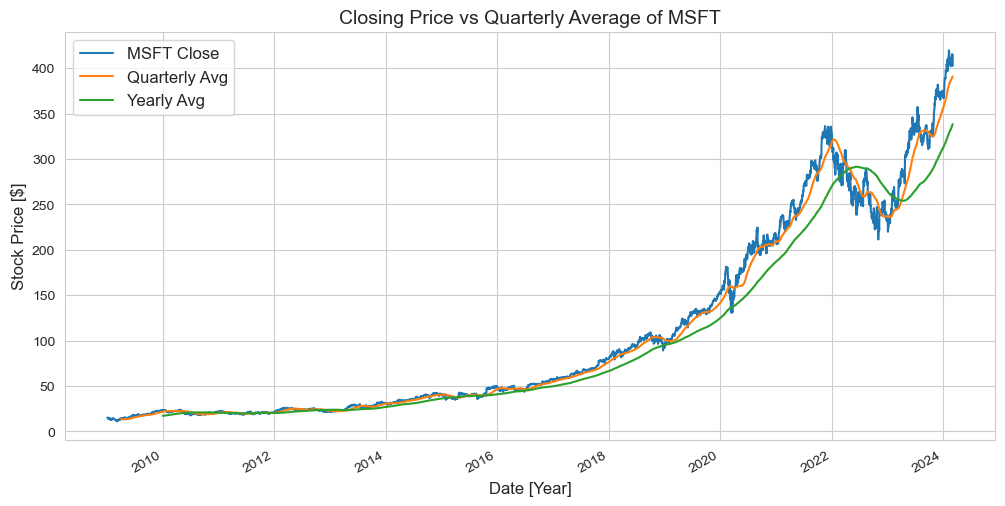

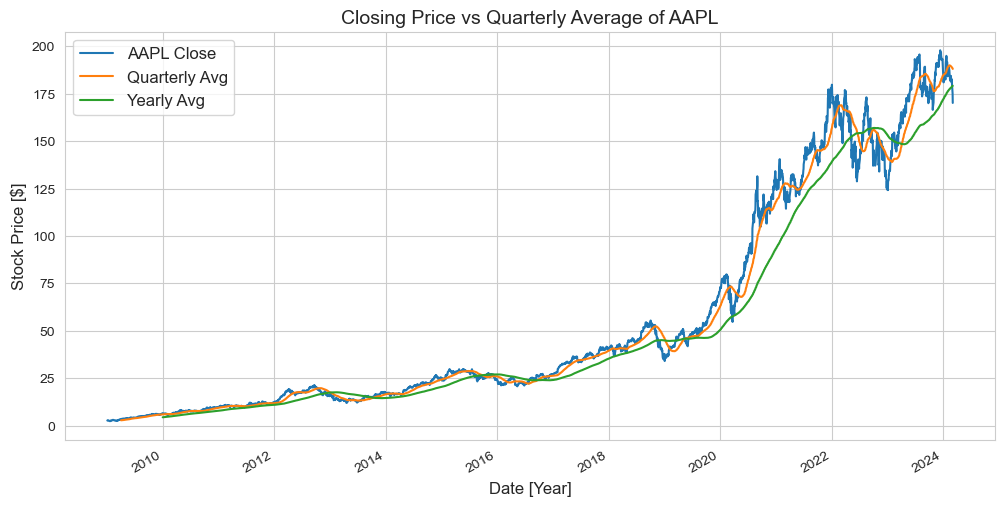

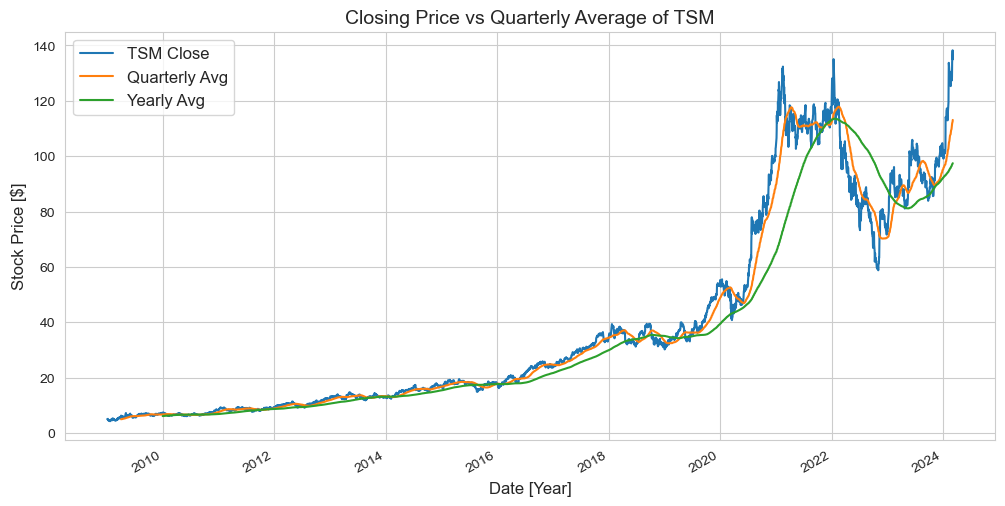

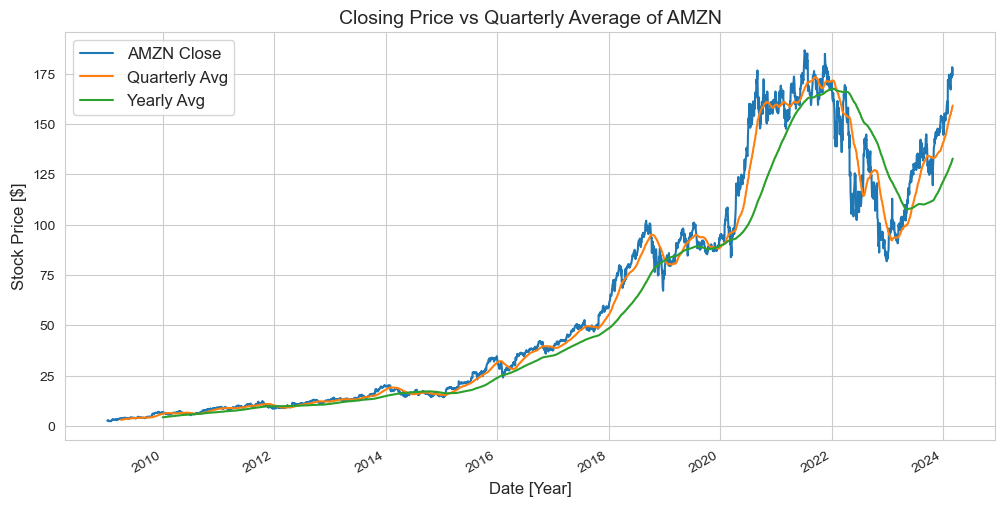

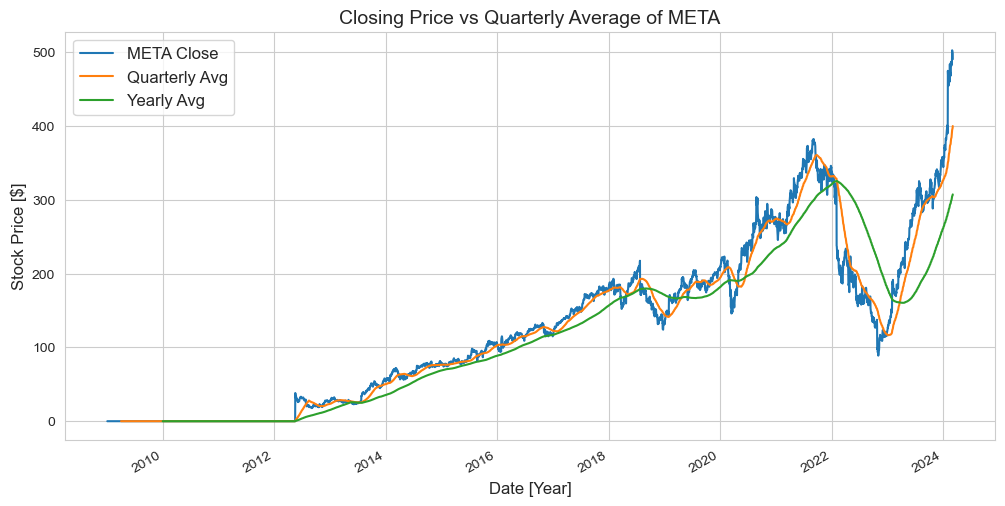

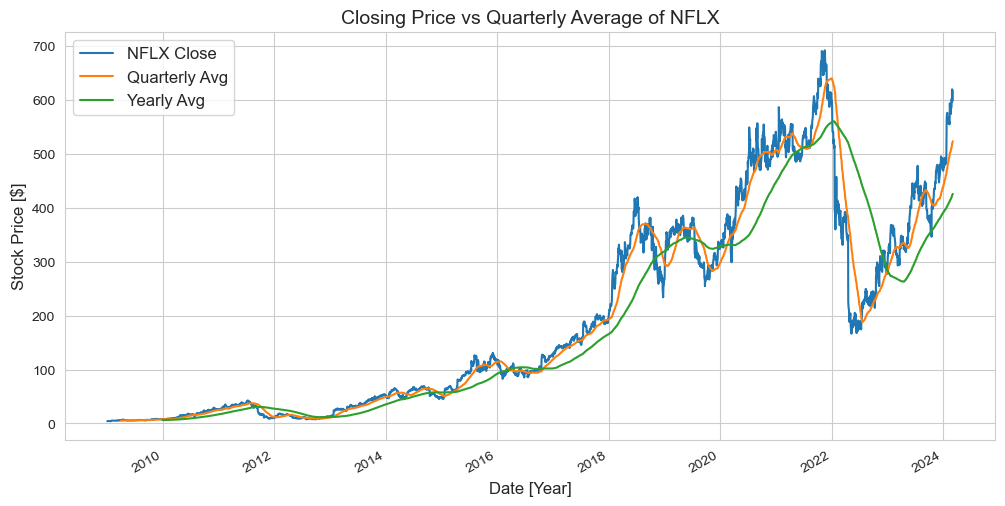

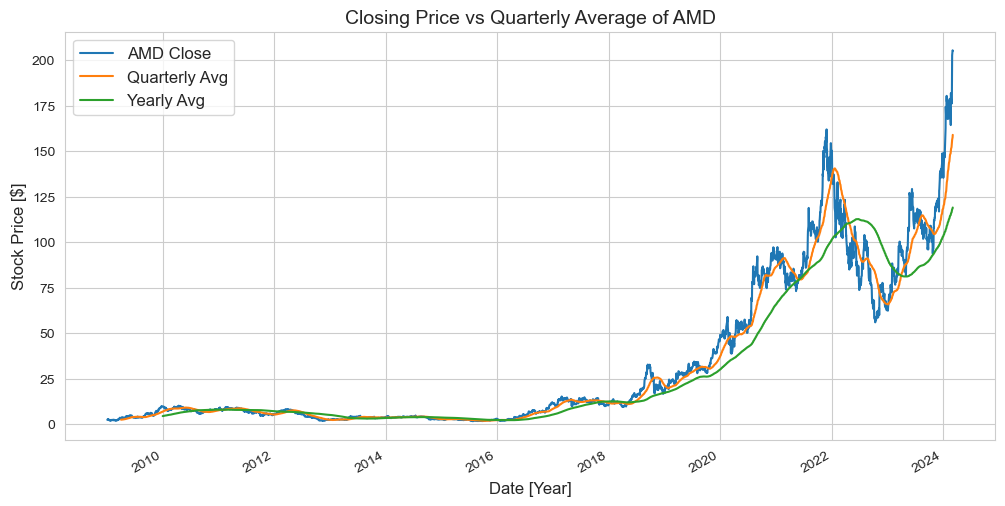

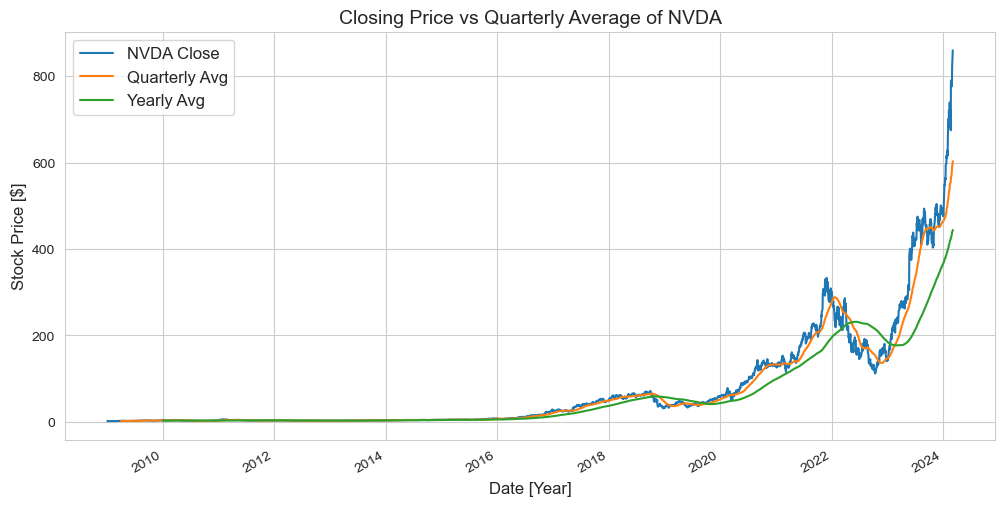

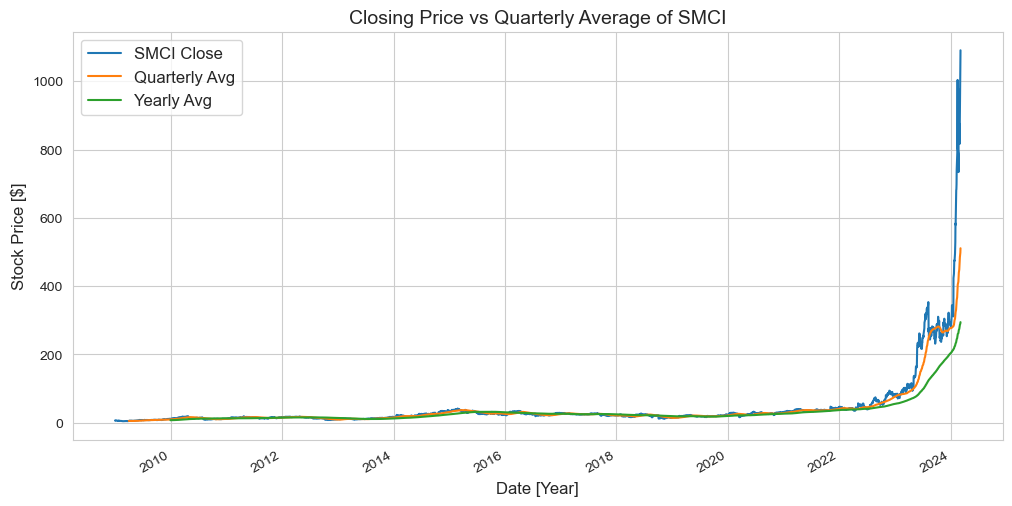

In [226]:
for idx in tic:
  plt.figure(figsize=(12,6))
  df[idx].loc['2009-01-01':].plot(label = '{} Close'.format(idx))
  df[idx].loc['2009-01-01':].rolling(window=63).mean().plot(label='Quarterly Avg')
  df[idx].loc['2009-01-01':].rolling(window=252).mean().plot(label='Yearly Avg')
  plt.xlabel('Date [Year]', fontsize = 12)
  plt.ylabel('Stock Price [$]', fontsize = 12)
  plt.legend(loc = 'best', fontsize = 12)
  plt.title('Closing Price vs Quarterly Average of {}'.format(idx), fontsize = 14)
  plt.show()

<Axes: xlabel='Ticker', ylabel='Ticker'>

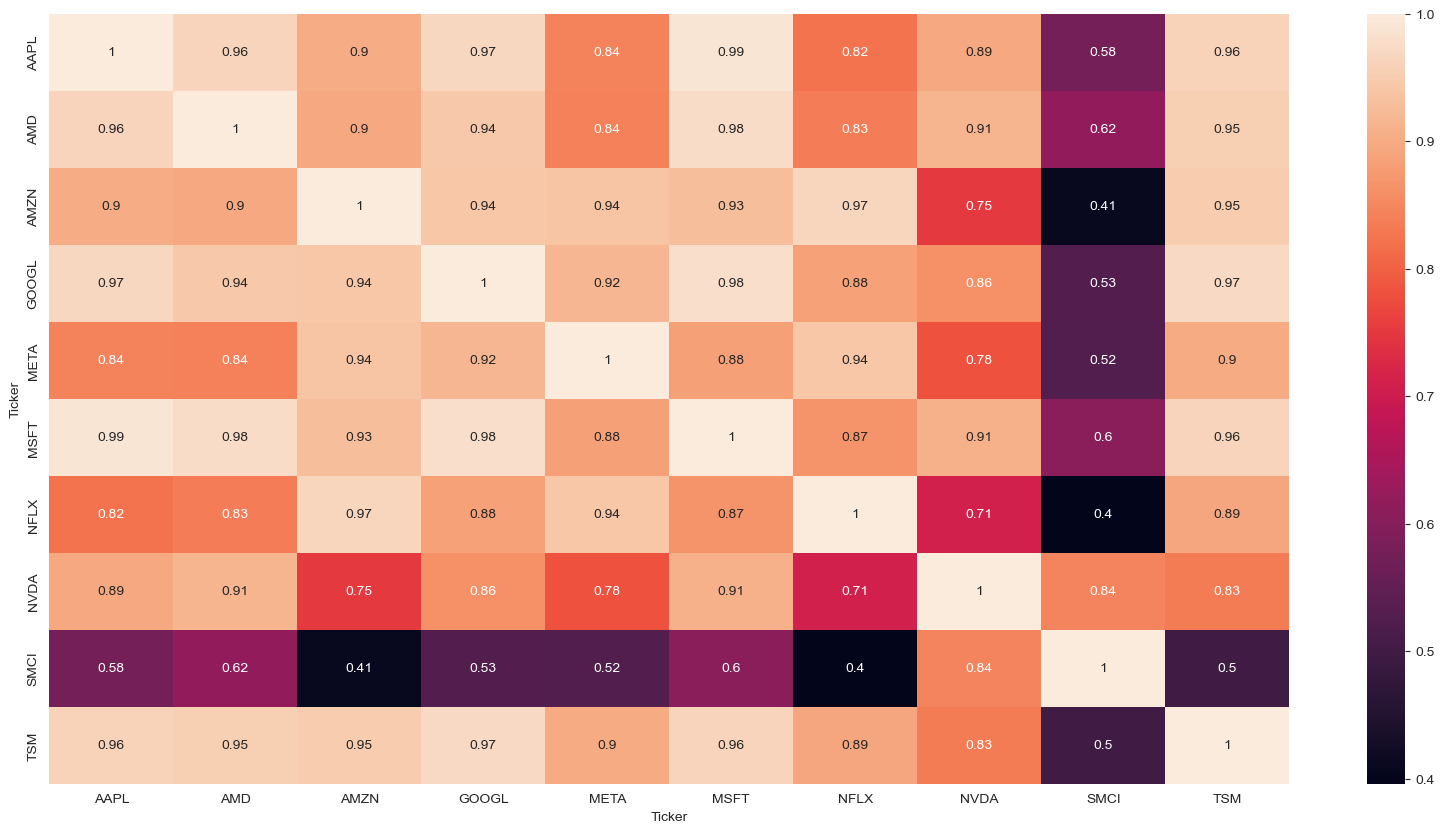

In [227]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

In [228]:
# Dropping Closing Price Column
stock_data = stock_data.drop('Close', 1)

In [229]:
#Remanimg Adj Close
stock_data = stock_data.rename(columns={'Adj Close':'AdjClose'})
#Resetting the index
stock_data = stock_data.reset_index()
#Sorting the data by Date and Ticker and resetting the index
stock_data = stock_data.sort_values(by= ['Date', 'Ticker']).reset_index(drop = True)

In [230]:
# Feature Engineering
# Extracting features from date column

stock_data['Day'] = stock_data['Date'].dt.dayofweek
stock_data['Week'] = stock_data['Date'].dt.week
stock_data['Month'] = stock_data['Date'].dt.month

In [231]:
uniq_date = stock_data.Date.unique()
stocks = pd.DataFrame({"Date": uniq_date})

In [232]:
stock_data_tech = pd.DataFrame()
#Make changes first calculate the technical indicators and then match all the stocks with dates and then backfill NaN with last observed valid data
for i in tic:

  #Forcing all all the date ranges to be same for all stocks #DOW
  temp = pd.merge(stocks, stock_data[stock_data.Ticker == i], how='left', on= 'Date')
  #Filling the missing values
  temp = temp.fillna(method='bfill')
  print('Shape of {} before merging : {} | after merging : {}'.format(i, stock_data[stock_data.Ticker == i].shape, temp.shape))
  #Adding all the available technical indicators
  stock_tech = ta.add_all_ta_features(df= temp, open= 'Open', high= 'High', low= 'Low', close='AdjClose', volume = 'Volume', fillna=True)
  stock_data_tech = stock_data_tech.append(stock_tech)

Shape of GOOGL before merging : (3818, 10) | after merging : (3818, 10)
Shape of MSFT before merging : (3818, 10) | after merging : (3818, 10)
Shape of AAPL before merging : (3818, 10) | after merging : (3818, 10)
Shape of TSM before merging : (3818, 10) | after merging : (3818, 10)
Shape of AMZN before merging : (3818, 10) | after merging : (3818, 10)
Shape of META before merging : (2967, 10) | after merging : (3818, 10)
Shape of NFLX before merging : (3818, 10) | after merging : (3818, 10)
Shape of AMD before merging : (3818, 10) | after merging : (3818, 10)
Shape of NVDA before merging : (3818, 10) | after merging : (3818, 10)
Shape of SMCI before merging : (3818, 10) | after merging : (3818, 10)


In [233]:
stock_data_tech[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]].sample(5)

,Date,Ticker,Open,High,Low,AdjClose,Volume,momentum_ppo,momentum_rsi,trend_adx,trend_macd,trend_cci
882,2012-07-03,TSM,14.350000,14.440000,14.280000,10.174901,5737000.0,-0.246352,58.964377,17.865582,-0.024118,188.494423
392,2010-07-26,GOOGL,12.239489,12.281031,12.134134,12.236486,79728192.0,0.335182,55.547326,19.083190,0.040048,87.864002
3267,2021-12-23,SMCI,42.660000,43.150002,42.630001,42.720001,126000.0,0.569058,54.543438,17.868765,0.238982,50.525830
3174,2021-08-12,TSM,115.550003,115.949997,114.440002,110.185692,6338400.0,-0.228695,44.172719,13.869652,-0.255455,-77.747935
885,2012-07-09,AMZN,11.250000,11.300000,11.172500,11.252500,38440000.0,1.287862,55.230760,17.768223,0.142972,46.217230


In [234]:
stock_data_tech[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]].head()

,Date,Ticker,Open,High,Low,AdjClose,Volume,momentum_ppo,momentum_rsi,trend_adx,trend_macd,trend_cci
0,2009-01-02,GOOGL,7.722723,8.053554,7.645145,8.041041,144275580.0,0.000000,100.000000,0.0,0.000000,0.000000
1,2009-01-05,GOOGL,8.033033,8.289289,7.882883,8.209459,195364440.0,0.166822,100.000000,0.0,0.013435,66.666667
2,2009-01-06,GOOGL,8.332833,8.528529,8.167918,8.359860,256750992.0,0.443349,100.000000,0.0,0.035806,100.000000
3,2009-01-07,GOOGL,8.216216,8.281031,7.976727,8.058308,179600220.0,0.357518,48.578080,0.0,0.028869,-11.069044
4,2009-01-08,GOOGL,7.964965,8.137888,7.941441,8.137888,143883972.0,0.364548,55.134776,0.0,0.029454,-27.641293


In [235]:
stock_data_tech[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]].tail()

,Date,Ticker,Open,High,Low,AdjClose,Volume,momentum_ppo,momentum_rsi,trend_adx,trend_macd,trend_cci
3813,2024-02-28,SMCI,820.000000,846.50000,812.000000,816.539978,6032500.0,14.458389,57.713365,57.441666,103.109300,40.522532
3814,2024-02-29,SMCI,839.000000,890.52002,839.000000,866.119995,8842900.0,13.727076,60.458626,56.696477,99.449454,60.186846
3815,2024-03-01,SMCI,881.880005,927.00000,881.000000,905.479980,9887600.0,13.360978,62.537872,56.236704,98.588554,79.452615
3816,2024-03-04,SMCI,1039.000000,1155.00000,1020.340027,1074.339966,20162100.0,14.454622,69.860226,56.848027,110.260855,189.346723
3817,2024-03-05,SMCI,1035.000000,1097.50000,976.099976,1090.829956,13304400.0,15.177739,70.467297,56.738255,119.464727,153.568734


In [236]:
"""
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, Shares_Per_Trade = 10, Initial_Investment = 10000, Action_Space = 10, Observation_Space = 211, day = 0, 
                 Normalized_Rewards = 1e-4, verbosity = 0, mode = 'train', seed = 10, commission = 0 ):

      self.day = day
      self.df = df
      self.max_shares_per_trade = Shares_Per_Trade
      self.initial_investment = Initial_Investment
      self.Action_Space = Action_Space
      self.Observation_Space = Observation_Space
      self.normalized_rewards = Normalized_Rewards
      self.verbosity = verbosity
      self.commission = commission
      #self.model = model
      self.mode = mode
      self._seed(seed)

      #************************
      self.ticker = df.Ticker.unique()


      #Action Space
      # Action > 0  means buy shares of stock
      # Action 0 means Hold the stock
      # Action < 0 means sell shares of stock
      self.action_space = spaces.Box(low = -1, high= 1,
                                     #Original: shape=(self.Action_Space,), dtype= np.int)
                                     shape=(self.Action_Space,), dtype= int)
      #Observation Space
      self.observation_space = spaces.Box(low = -np.inf, high= np.inf, shape=(self.Observation_Space,))
      #Selecting the Data for one date
      self.data = self.df.loc[self.day,:]
      #Initial Run
      self.initial = True
      #Verify if tradings days are completed or not
      self.done = False
      #Rewards
      self.reward = 0
      #Asset value after each trading day
      self.asset_memory = [self.initial_investment]
      #Rewards received for each trading day i.e profit or loss
      self.reward_memory = []
      #Saving the date for the trade
      self.date_memory = [self.data.Date.unique()[0]]
      #Initializing state of the environment
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()

      #************************
      self.keep_row_info = {}
      self.keep_rows_list = []




    def render(self, mode='human'):
      return self.state

    # This method is used to reset the values of the state to it's default after every episode
    def reset(self):
      #print(" ")
      #print("reseting self...")

      self.day = 0
      self.reward = 0
      self.data = self.df.loc[self.day,:]
      self.done = False
      self.initial = False
      self.reward_memory = []
      self.date_memory = [str(self.data.Date.unique()[0])]
      self.asset_memory = [self.initial_investment]
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()


      #************************
      self.keep_row_info = {}
      self.keep_rows_list = []



      #print(self.state)
      return self.state

    def step(self, actions):

      #************************

      #print(' ')
      #print('************--start--************')
      self.keep_row_info = {}

      keep_day = self.day
      

      date_string = str(self.data.Date.unique()[0])
      date_unix = self.data.Date.unique()
      date_string2 = date_string.split('T')[0]
      date_object = datetime.strptime(date_string2, "%Y-%m-%d")
      formatted_date = date_object.strftime("%Y-%m-%d")

      format_string = '%Y-%m-%dT%H:%M:%S.%f'
      date_stringA = date_string[:-3] + date_string[-3:].rstrip('0')
      datetime_object2 = datetime.strptime(date_stringA, format_string)
      unix_time = datetime_object2.timestamp()

      #print(' ')
      #print('Day:                            ' + str(keep_day))
      #print('Date_str:                       ' + date_string)
      #print('Date_unix:                      ' + str(unix_time))
      #print('Date (formatted):               ' + str(formatted_date))

      self.keep_row_info['day'] = str(keep_day)
      self.keep_row_info['date_str'] = date_string
      self.keep_row_info['date_unix'] = str(unix_time)
      self.keep_row_info['date_formatted'] = str(formatted_date)


      self.done = self.day >= len(self.df.Date.unique())-1
      #Use this to save the results to csv after we performed trading for all the days
      if self.done:

        keep_df = pd.DataFrame(index = [x for x in range(len(self.keep_rows_list))],data = self.keep_rows_list)

        #print('Keep DF')
        #print(keep_df)

        final_portfolio_value = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        total_rewards = final_portfolio_value - self.initial_investment
        profit_pct = (total_rewards*100)/self.initial_investment
        asset_df = pd.DataFrame(self.asset_memory)
        asset_df.columns = ['portfolio']
        asset_df['date'] = self.date_memory
        if self.verbosity and self.mode != 'train':
          #print(len(self.reward_memory))
          #if self.mode == 'trade' or self.mode == 'val':

          asset_df['date'] = self.date_memory


          print( 'Initial Portfolio Value : {} | Final Portfolio Value : {} | Total rewards : {} | % of profit : {}'.format(self.initial_investment, final_portfolio_value,total_rewards, profit_pct))
          #asset_df.to_csv('{}_{}_results.csv'.format(self.mode, self.commission))
          keep_df.to_csv('keep_df_results.csv')


        #************************
        #keep_df = pd.DataFrame(keep_day_list, columns=['date'], index = [x for x in range(len(keep_day_list))])
        #keep_df['portfolio_before_trade'] = keep_portfolio_before_trade_list
        #keep_df['available_cash_after_trading'] = keep_available_cash_after_trading_list
        #keep_df['shares_available_per_stock_list'] = keep_shares_available_per_stock_list
        #keep_df['profit_and_loss_for_day'] = keep_profit_and_loss_for_day

        #print(keep_df)

        #keep_df.to_csv('keep_results.csv')

        return self.state, self.reward, self.done, {}

      else:

        #Calculating the portfolio value before start of trading
        #Available investment amount + sum of value of each stock held (no.of shares per stock * price of the stock on that day)
        portfolio_before_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        #************************
        keep_portfolio_before_trade = portfolio_before_trade
        #keep_portfolio_before_trade_list.append(keep_portfolio_before_trade)
        keep_available_cash_before_trading = self.state[0]

        #Extracting the indicies of sell action
        #if actions is not an array then convert it to array using np.array()
        sell_indices = np.where(actions <  0 )[0]
        #Extracting the indicies of buy action
        buy_indices = np.where(actions >  0 )[0]


        #************************
        #Hold indicies
        hold_indices = np.where(actions ==  0 )[0]



        #print(actions)
        #print(self.ticker)


        ###### Trading starts #######
        # Initially selling the stocks to increase investment value
        for idx in sell_indices:

          #************************
          #print("Stock to sell: " + str(idx))
          sell_ticker_symbol = self.ticker[idx]
          #print('Ticker: ' + str(sell_ticker_symbol))

          stock_to_sell_ticker = 'Stock_to_sell_' + str(sell_ticker_symbol)
          self.keep_row_info[stock_to_sell_ticker] = 'Yes'


          #Sell stock if price is > 0 and shares held > 0
          if self.state[idx+1] > 0 and self.state[idx+self.Action_Space+1] > 0:

            #No of shares to sell
            shares_sell = min(self.state[idx+self.Action_Space+1], abs(actions[idx]*self.max_shares_per_trade))
            
            num_of_ticker_shares_available_before_selling = 'num_of_' + str(sell_ticker_symbol) + 'shares_available_before_selling'
            self.keep_row_info[num_of_ticker_shares_available_before_selling] = str(self.state[idx+self.Action_Space+1])

            #************************
            #print('No. of shares to sell: ' + str(shares_sell))
            num_of_ticker_to_sell = 'num_of_' + str(sell_ticker_symbol) + '_to_sell:'
            self.keep_row_info[num_of_ticker_to_sell] = str(shares_sell)

            #Updating the available cash after selling the stocks
            self.state[0] += self.state[idx+1]*shares_sell*(1-self.commission)

            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] -= shares_sell

            #************************
            #print('No. of shares available after selling: ' + str(self.state[idx+self.Action_Space+1]))
            num_of_ticker_shares_available_after_selling = 'num_of_' + str(sell_ticker_symbol) + 'shares_available_after_selling'
            self.keep_row_info[num_of_ticker_shares_available_after_selling] = str(self.state[idx+self.Action_Space+1])


            stock_info_df = self.df
            wanted_df_1 = stock_info_df[stock_info_df['Date'] == date_string]
            wanted_df_2 = wanted_df_1[wanted_df_1['Ticker'] == sell_ticker_symbol]
            wanted_df_2 = wanted_df_2[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]]
            

            for w_column in wanted_df_2.columns.tolist():
              #print(str(sell_ticker_symbol))
              #print(str(w_column))
              #print(str(wanted_df_2[w_column].values.tolist()[0]))
              #print(str(sell_ticker_symbol) + '_' + str(w_column)+ ' : ' + str(wanted_df_2[w_column].values.tolist()))
                
              self.keep_row_info[str(sell_ticker_symbol) + '_' + str(w_column)] = str(wanted_df_2[w_column].values.tolist()[0])
              #pass



          else:
            # print('No Shares to sell')
            pass
        #print('Buying Stock shares : ')
        for idx in buy_indices:

          #************************
          #print("Stock to buy: " + str(idx))
          buy_ticker_symbol = self.ticker[idx]
          #print('Ticker: ' + str(buy_ticker_symbol))

          stock_to_buy_ticker = 'Stock_to_buy_' + str(buy_ticker_symbol)
          self.keep_row_info[stock_to_buy_ticker] = 'Yes'

          #Buy stocks if price is > 0
          if self.state[idx+1] > 0 and self.state[0] > 0:

            #Max number of shares that can be brought with the available cash (available cash / stock price)
            max_shares_buy = self.state[0]*(1 - self.commission)//self.state[idx+1]
            #No of shares to buy
            shares_buy = min(max_shares_buy, actions[idx]*self.max_shares_per_trade)
            
            num_of_ticker_shares_available_before_buying = 'num_of_' + str(buy_ticker_symbol) + 'shares_available_before_buying'
            self.keep_row_info[num_of_ticker_shares_available_before_buying] = str(self.state[idx+self.Action_Space+1])

            #************************
            #print('No. of shares to buy: ' + str(shares_buy))
            num_of_ticker_to_buy = 'num_of_' + str(buy_ticker_symbol) + '_to_buy:'
            self.keep_row_info[num_of_ticker_to_buy] = str(shares_buy)

            #Updating the available cash after buying the stocks
            self.state[0] -= self.state[idx+1]*shares_buy*(1 + self.commission)

            #Updating the available stocks after buying
            self.state[idx+self.Action_Space+1] += shares_buy

            #************************
            #print('No. of shares available after buying: ' + str(self.state[idx+self.Action_Space+1]))
            num_of_ticker_shares_available_after_buying = 'num_of_' + str(buy_ticker_symbol) + 'shares_available_after_buying'
            self.keep_row_info[num_of_ticker_shares_available_after_buying] = str(self.state[idx+self.Action_Space+1])

            stock_info_df = self.df
            wanted_df_1 = stock_info_df[stock_info_df['Date'] == date_string]
            wanted_df_2 = wanted_df_1[wanted_df_1['Ticker'] == buy_ticker_symbol]
            wanted_df_2 = wanted_df_2[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]]
            

            for w_column in wanted_df_2.columns.tolist():
              #print(str(sell_ticker_symbol))
              #print(str(w_column))
              #print(str(wanted_df_2[w_column].values.tolist()[0])
              #print(str(sell_ticker_symbol) + '_' + str(w_column)+ ' : ' + str(wanted_df_2[w_column].values.tolist()))
                
              self.keep_row_info[str(buy_ticker_symbol) + '_' + str(w_column)] = str(wanted_df_2[w_column].values.tolist()[0])  
              #pass

          else:

            #************************
            for idx in hold_indices:
              #print("Stock to hold: " + str(idx))
              hold_ticker_symbol = self.ticker[idx]
              #print('Ticker: ' + str(hold_ticker_symbol))

              stock_to_hold_ticker = 'Stock_to_hold_' + str(hold_ticker_symbol)
              self.keep_row_info[stock_to_hold_ticker] = 'Yes'
            
              num_of_ticker_shares_available_for_holding = 'num_of_' + str(hold_ticker_symbol) + 'shares_available_for_holding'
              self.keep_row_info[num_of_ticker_shares_available_for_holding] = str(self.state[idx+self.Action_Space+1])
                
              stock_info_df = self.df
              wanted_df_1 = stock_info_df[stock_info_df['Date'] == date_string]
              wanted_df_2 = wanted_df_1[wanted_df_1['Ticker'] == hold_ticker_symbol]
              wanted_df_2 = wanted_df_2[['Date', 'Ticker', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]]
            

              for w_column in wanted_df_2.columns.tolist():
                #print(str(sell_ticker_symbol))
                #print(str(w_column))
                #print(str(wanted_df_2[w_column].values.tolist()[0]))
                #print(str(hold_ticker_symbol) + '_' + str(w_column)+ ' : ' + str(wanted_df_2[w_column].values.tolist()))
                
                self.keep_row_info[str(hold_ticker_symbol) + '_' + str(w_column)] = str(wanted_df_2[w_column].values.tolist()[0])
                #pass

            # print('No Shares purchased')
            pass
        ###### Trading ends #######
        # print('*************** Trading Ends ***************')
        # print('Available cash for after trading : {}'.format(self.state[0]))
        # print('Shares available per stock : '.format(np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1])))
        # print('Over all portfolie before Trading : {}'.format(portfolio_after_trade))
        # print('Profit or Loss for Day {} : {} is {}'.format(self.day, self.date_memory[-1], self.reward))

        #************************
        keep_available_cash_after_trading = self.state[0]
        keep_shares_available_per_stock = np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1])
        keep_profit_and_loss_for_day = self.reward
        #keep_available_cash_after_trading_list.append(keep_available_cash_after_trading)
        #keep_shares_available_per_stock_list.append(keep_shares_available_per_stock)
        #keep_profit_and_loss_for_day_list.append(Keep_profit_and_loss_for_day)




        #Setting the values for next trading date
        self.day += 1

        #************************
        #keep_day = self.day
        #keep_day_list.append(keep_date)

        #date_string = str(self.data.Date.unique()[0])
        #date_string2 = date_string.split('T')[0]
        #date_object = datetime.strptime(date_string2, "%Y-%m-%d")
        #formatted_date = date_object.strftime("%d/%m/%Y")


        #print('Day:                            ' + str(keep_day))
        #print('Date:                          ' + date_string)
        #print('Date (formatted):               ' + str(formatted_date))
        #print('Portfolio value before trading: ' + str(keep_portfolio_before_trade))



        self.data = self.df.loc[self.day,:]

        self.state = [self.state[0]] + self.data.AdjClose.values.tolist() + list(self.state[(self.Action_Space+1):(2*self.Action_Space)+1]) + \
                      self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
                      self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
                      self.data.trend_cci.values.tolist()


        portfolio_after_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        #************************
        keep_portfolio_after_trade = portfolio_after_trade
        #print('Portfolio value after trading:  ' + str(keep_portfolio_after_trade))
        #print('Available Cash before trading:  ' + str(keep_available_cash_before_trading))
        #print('Available Cash after trading:   ' + str(keep_available_cash_after_trading))
        #print('Profit and loss for day:        ' + str(keep_profit_and_loss_for_day))

        self.keep_row_info['portfolio_value_after_trading'] = str(keep_portfolio_after_trade)
        self.keep_row_info['available_cash_before_trading'] = str(keep_available_cash_before_trading)
        self.keep_row_info['available_cash_after_trading'] = str(keep_available_cash_after_trading)
        self.keep_row_info['profit_and_loss_for_day'] = str(keep_profit_and_loss_for_day)

        #Total trade in a day (profit or loss)
        self.reward = portfolio_after_trade - portfolio_before_trade
        #print('Day : {} | Reward : {}'.format(self.day-1, self.reward))
        self.reward_memory.append(self.reward)
        self.asset_memory.append(portfolio_after_trade)
        self.date_memory.append(self.data.Date.unique()[0])
        self.reward = self.reward*self.normalized_rewards     #Normalizing the reward

        self.keep_rows_list.append(self.keep_row_info)
        #print(self.keep_rows_list)

        return self.state, self.reward, self.done, {}

    def _seed(self, seed = 10):
      randomState, seed = seeding.np_random(seed)
      return [seed]

    #added for seed
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
"""

'\nclass StockTradingEnv(gym.Env):\n    metadata = {\'render.modes\': [\'human\']}\n    \n    def __init__(self, df, Shares_Per_Trade = 10, Initial_Investment = 10000, Action_Space = 10, Observation_Space = 211, day = 0, \n                 Normalized_Rewards = 1e-4, verbosity = 0, mode = \'train\', seed = 10, commission = 0 ):\n\n      self.day = day\n      self.df = df\n      self.max_shares_per_trade = Shares_Per_Trade\n      self.initial_investment = Initial_Investment\n      self.Action_Space = Action_Space\n      self.Observation_Space = Observation_Space\n      self.normalized_rewards = Normalized_Rewards\n      self.verbosity = verbosity\n      self.commission = commission\n      #self.model = model\n      self.mode = mode\n      self._seed(seed)\n\n      #************************\n      self.ticker = df.Ticker.unique()\n\n\n      #Action Space\n      # Action > 0  means buy shares of stock\n      # Action 0 means Hold the stock\n      # Action < 0 means sell shares of stock\n  

In [237]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, Shares_Per_Trade = 10, Initial_Investment = 10000, Action_Space = 30, Observation_Space = 211, day = 0, 
                 Normalized_Rewards = 1e-4, verbosity = 0, mode = 'train', seed = 10, commission = 0 ):
      
      self.day = day
      self.df = df
      self.max_shares_per_trade = Shares_Per_Trade
      self.initial_investment = Initial_Investment
      self.Action_Space = Action_Space
      self.Observation_Space = Observation_Space
      self.normalized_rewards = Normalized_Rewards
      self.verbosity = verbosity
      self.commission = commission
      #self.model = model
      self.mode = mode
      self._seed(seed)
      #Action Space
      # Action > 0  means buy shares of stock
      # Action 0 means Hold the stock
      # Action < 0 means sell shares of stock
      self.action_space = spaces.Box(low = -1, high= 1, 
                                     shape=(self.Action_Space,), dtype= int)
      #Observation Space
      self.observation_space = spaces.Box(low = -np.inf, high= np.inf, shape=(self.Observation_Space,))
      #Selecting the Data for one date
      self.data = self.df.loc[self.day,:]
      #Initial Run
      self.initial = True
      #Verify if tradings days are completed or not
      self.done = False
      #Rewards
      self.reward = 0
      #Asset value after each trading day
      self.asset_memory = [self.initial_investment]
      #Rewards received for each trading day i.e profit or loss
      self.reward_memory = []
      #Saving the date for the trade
      self.date_memory = [self.data.Date.unique()[0]]
      #Initializing state of the environment
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()
    
    def render(self, mode='human'):
      return self.state
    
    # This method is used to reset the values of the state to it's default after every episode
    def reset(self):
      
      self.day = 0
      self.reward = 0
      self.data = self.df.loc[self.day,:]
      self.done = False
      self.initial = False
      self.reward_memory = []
      self.date_memory = [self.data.Date.unique()[0]]
      self.asset_memory = [self.initial_investment]
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()
      #print(self.state)
      return self.state
    
    def step(self, actions):
      self.done = self.day >= len(self.df.Date.unique())-1
      #Use this to save the results to csv after we performed trading for all the days
      if self.done:
        
        final_portfolio_value = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        
        total_rewards = final_portfolio_value - self.initial_investment
        profit_pct = (total_rewards*100)/self.initial_investment
        asset_df = pd.DataFrame(self.asset_memory)
        asset_df.columns = ['portfolio']
        asset_df['date'] = self.date_memory
        if self.verbosity and self.mode != 'train':
          #print(len(self.reward_memory))
          #if self.mode == 'trade' or self.mode == 'val':
          print( 'Initial Portfolio Value : {} | Final Portfolio Value : {} | Total rewards : {} | % of profit : {}'.format(self.initial_investment, final_portfolio_value,total_rewards, profit_pct))
          asset_df.to_csv('{}_{}_results'.format(self.mode, self.commission))
        return self.state, self.reward, self.done, {}
      
      else:
        #Calculating the portfolio value before start of trading 
        #Available investment amount + sum of value of each stock held (no.of shares per stock * price of the stock on that day)
        portfolio_before_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        #Extracting the indicies of sell action
        #if actions is not an array then convert it to array using np.array()
        sell_indices = np.where(actions <  0 )[0]
        #Extracting the indicies of buy action
        buy_indices = np.where(actions >  0 )[0]
        
        
        ###### Trading starts #######
        # Initially selling the stocks to increase investment value
        for idx in sell_indices:
          #Sell stock if price is > 0 and shares held > 0
          if self.state[idx+1] > 0 and self.state[idx+self.Action_Space+1] > 0:
            
            #No of shares to sell
            shares_sell = round(min(self.state[idx+self.Action_Space+1], abs(actions[idx]*self.max_shares_per_trade)))
            #Updating the available cash after selling the stocks
            self.state[0] += self.state[idx+1]*shares_sell*(1-self.commission)
            
            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] -= shares_sell
          else:
            # print('No Shares to sell')
            pass
        #print('Buying Stock shares : ')
        for idx in buy_indices:
          #Buy stocks if price is > 0
          if self.state[idx+1] > 0 and self.state[0] > 0:
            
            #Max number of shares that can be brought with the available cash (available cash / stock price)
            max_shares_buy = self.state[0]*(1 - self.commission)//self.state[idx+1]
            #No of shares to buy
            shares_buy = round(min(max_shares_buy, actions[idx]*self.max_shares_per_trade))
            #Updating the available cash after selling the stocks
            self.state[0] -= self.state[idx+1]*shares_buy*(1 + self.commission)
            
            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] += shares_buy
          
          else:
            # print('No Shares purchased')
            pass
        
        
        ###### Trading ends #######
        # print('*************** Trading Ends ***************')
        # print('Available cash for after trading : {}'.format(self.state[0]))
        # print('Shares available per stock : '.format(np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1])))
        # print('Over all portfolie before Trading : {}'.format(portfolio_after_trade))
        # print('Profit or Loss for Day {} : {} is {}'.format(self.day, self.date_memory[-1], self.reward))
        
        #Setting the values for next trading date
        self.day += 1
        self.data = self.df.loc[self.day,:]
        
        self.state = [self.state[0]] + self.data.AdjClose.values.tolist() + list(self.state[(self.Action_Space+1):(2*self.Action_Space)+1]) + \
                      self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
                      self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
                      self.data.trend_cci.values.tolist()
        
        
        portfolio_after_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        #Total trade in a day (profit or loss)
        self.reward = portfolio_after_trade - portfolio_before_trade
        #print('Day : {} | Reward : {}'.format(self.day-1, self.reward))
        self.reward_memory.append(self.reward)
        self.asset_memory.append(portfolio_after_trade)
        self.date_memory.append(self.data.Date.unique()[0])
        self.reward = self.reward*self.normalized_rewards     #Normalizing the reward
        
        #print(str(self.reward))
        
        return self.state, self.reward, self.done, {}
    
    def _seed(self, seed = 10):
      randomState, seed = seeding.np_random(seed)
      return [seed]

    #added for seed
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [238]:
def render_trading(model, env, data, n_episodes = 1):
  episode_rewards = [0.0]
  obs = env.reset()
  env.render()

  for i in range(n_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs)
        print(action)
        obs, rewards, done, info = env.step(action)
        env.render()
        # Stats
        if done:
          obs = train_env.reset()
          #print('Episode {} Rewards {}'.format(i+1, episode_rewards[-1]))
          episode_rewards.append(0.0)
        else:
          #print(rewards)
          episode_rewards[-1] += rewards
    if (i+1)%10 == 0 and i != 0:
      print('Average reward {}'.format(np.average(episode_rewards[:i+1])))

  return episode_rewards

In [239]:
stock_df = stock_data_tech.copy()

In [240]:
#Training Data - 2009 --> 2015
train_data = stock_df[(stock_df.Date >= '2009-01-01') & (stock_df.Date < '2023-01-01')].sort_values(by=['Date', 'Ticker'])
#Validation Data - 2016
validation_data = stock_df[(stock_df.Date >= '2023-01-01') & (stock_df.Date < '2024-03-04')]
validation_data.sort_values(["Date", "Ticker"], ignore_index=True)
validation_data.index = validation_data.Date.factorize()[0]
#Trading Data - 2017 --> 2021
trading_data = stock_df[(stock_df.Date >= '2024-03-04')]
trading_data.sort_values(["Date", "Ticker"], ignore_index=True)
trading_data.index = trading_data.Date.factorize()[0]

In [241]:
# Environment Parameters
Shares_Per_Trade = 5                        # Maximum shares that can be purchased or sold in a trade
Initial_Investment = 10000                  # Initial Investment
Action_Space = 10                           # Number of stocks
Observation_Space = 1 + 10 + 10 + 10*5      # Initial Investment + Stocks Closing Prices + Shares holding per stock + stocks * Technical Indicators
Normalized_Rewards = 1e-2                   # Factor used to normalized the rewards
commission = 0                              # Commission for trading

In [242]:
#Training Environment
train_env = DummyVecEnv([lambda : StockTradingEnv(train_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=0,
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
print(train_env)

In [243]:
train_env = VecNormalize(train_env, norm_reward=False)
print(train_env)

In [244]:
#Validation Environment
val_env = DummyVecEnv([lambda : StockTradingEnv(validation_data, Shares_Per_Trade,
                                                Initial_Investment, Action_Space,
                                                Observation_Space, verbosity=0, mode='val',
                                                Normalized_Rewards= Normalized_Rewards,
                                                commission = commission)])
print(val_env)

In [245]:
val_env = VecNormalize(val_env, norm_reward=False)
print(val_env)

In [246]:
#Trading Environment
trade_env = DummyVecEnv([lambda : StockTradingEnv(trading_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=1, mode='trade',
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
print(trade_env)

In [247]:
trade_env = VecNormalize(trade_env, norm_reward=False)
print(trade_env)

In [248]:
#Original

#a2c_model = A2C('MlpPolicy', train_env, seed= 10,
#                #tensorboard_log= './log',
#                verbose= 1, learning_rate= 0.0005, ent_coef= 0.01, n_steps=5, gamma=0.1)

#a2c_model.learn(total_timesteps=50000, log_interval= 10000, eval_env=val_env, eval_log_path='Validation', n_eval_episodes= 10, eval_freq=10000)

In [249]:
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback

# Assuming 'env' is your training environment and 'val_env' is your evaluation environment
a2c_model = A2C('MlpPolicy', env = train_env, seed= 10,
                #tensorboard_log= './log',
                verbose= 1, learning_rate= 0.0005, ent_coef= 0.01, n_steps=5, gamma=0.1)

# Setup the evaluation callback
eval_callback = EvalCallback(eval_env=val_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=10000,
                             deterministic=True, render=False)


Using cpu device


In [250]:
# Pass the callback to the model's learn method
a2c_model.learn(total_timesteps=50000, log_interval= 10000, callback=eval_callback)


Eval num_timesteps=10000, episode_reward=82.60 +/- 6.94
Episode length: 292.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 292      |
|    mean_reward        | 82.6     |
| time/                 |          |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -14.3    |
|    explained_variance | 0.0066   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | -249     |
|    std                | 1.02     |
|    value_loss         | 1.12e+03 |
------------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=80.84 +/- 8.07
Episode length: 292.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 292      |
|    mean_reward        | 80.8     |
| time/                 |          |
|    total_timesteps    | 20000    |
| train/                |

In [251]:
#Training 2009 --> 2022
#train_trade_return = render_trading(a2c_model, train_env, train_data, n_episodes = 100)

In [252]:
#val data 2023
#val_trade_return = render_trading(a2c_model, val_env, validation_data, n_episodes = 100)

#val_trade_return_list = []
#for i in range(100):
#    val_trade_return_list.append(str(val_trade_return[i][0]))
    
#turn_lr_a2c_df = pd.DataFrame(val_trade_return_list)
#turn_lr_a2c_df.to_csv('tune_lr_a2c.csv')

In [253]:
#Trading data --- today
trade_trade_return = render_trading(a2c_model, trade_env, trading_data, n_episodes = 1)

[[-0.38913476 -1.         -1.         -0.18776861  0.93621361  1.
  -0.37204757 -1.         -1.          0.52654457]]
[[-1.          1.          1.          1.         -1.         -1.
   0.64864695  1.          1.          1.        ]]
Initial Portfolio Value : 10000 | Final Portfolio Value : 9992.319931030273 | Total rewards : -7.6800689697265625 | % of profit : -0.07680068969726563


In [254]:
#Trading data --- today
trade_trade_return = render_trading(a2c_model, trade_env, trading_data, n_episodes = 10)

[[ 1.         -0.23056337 -1.         -1.          1.          1.
  -0.91214812 -1.         -1.         -1.        ]]
[[-1.         -0.00540712  0.39797738  1.         -0.38780272 -0.94017774
   1.          1.          1.         -0.89195859]]
Initial Portfolio Value : 10000 | Final Portfolio Value : 9939.449920654297 | Total rewards : -60.550079345703125 | % of profit : -0.6055007934570312
[[ 1.          1.         -1.         -0.09097564  0.47032154  1.
  -1.          0.61166918 -1.         -1.        ]]
[[-1.          0.50385416  1.          1.         -1.         -1.
   0.93054903  0.78747034  1.          1.        ]]
Initial Portfolio Value : 10000 | Final Portfolio Value : 9887.789855957031 | Total rewards : -112.21014404296875 | % of profit : -1.1221014404296874
[[ 1.         -1.          0.8573302   0.26072419  1.          1.
  -0.10010028 -1.         -1.          1.        ]]
[[-1.         -0.21056008  1.          0.80532312 -1.         -1.
   1.          1.          1.       

In [43]:
#CSV File

In [44]:
import pandas
csvFile = pandas.read_csv('keep_df_results.csv')
csvFile.head()

,Unnamed: 0,day,date_str,date_unix,date_formatted,Stock_to_sell_GOOGL,Stock_to_sell_MSFT,Stock_to_sell_AMZN,Stock_to_sell_NVDA,Stock_to_sell_SMCI,...,MSFT_AdjClose,MSFT_Volume,MSFT_momentum_ppo,MSFT_momentum_rsi,MSFT_trend_adx,MSFT_trend_macd,MSFT_trend_cci,num_of_MSFTshares_available_before_selling,num_of_MSFT_to_sell:,num_of_MSFTshares_available_after_selling
0,0,0,2024-01-02T00:00:00.000000000,1.704182e+09,2024-01-02,Yes,Yes,Yes,Yes,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2024-01-03T00:00:00.000000000,1.704269e+09,2024-01-03,NaN,Yes,Yes,Yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2024-01-04T00:00:00.000000000,1.704355e+09,2024-01-04,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2024-01-05T00:00:00.000000000,1.704442e+09,2024-01-05,Yes,Yes,Yes,Yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2024-01-08T00:00:00.000000000,1.704701e+09,2024-01-08,NaN,NaN,Yes,NaN,Yes,...,373.998383,23134000.0,0.290277,55.668729,18.218169,1.074625,30.28377,NaN,NaN,NaN


In [45]:
import pandas as pd

# Assuming csvFile is your existing DataFrame

# Define the columns that should appear first
fixed_columns = [
    'Unnamed: 0',
    'day',
    'date_str',
    'date_unix',
    'date_formatted',
    'portfolio_value_after_trading',
    'available_cash_before_trading',
    'available_cash_after_trading',
    'profit_and_loss_for_day'
]

# List of stock symbols
stock_symbols = ['GOOGL', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'META', 'NFLX', 'AMD', 'NVDA', 'SMCI']

# Initialize an empty dictionary to hold columns for each stock
stock_columns = {symbol: [] for symbol in stock_symbols}

# Iterate over columns in the DataFrame and assign them to the correct stock symbol or skip if in fixed columns
for column in csvFile.columns:
    if column in fixed_columns:
        continue  # Skip the fixed columns
    for symbol in stock_symbols:
        if symbol in column:
            stock_columns[symbol].append(column)
            break

# Sort the columns within each stock symbol group
for symbol in stock_columns:
    stock_columns[symbol] = sorted(stock_columns[symbol])

# Flatten the dictionary of columns into a single list maintaining the group order
sorted_columns = [col for symbol in stock_symbols for col in stock_columns[symbol]]

# Concatenate the fixed columns with the sorted stock columns
final_columns_order = fixed_columns + sorted_columns

# Add any remaining columns that do not fit into the stock symbol groups or fixed columns at the end
remaining_columns = [col for col in csvFile.columns if col not in final_columns_order]
final_columns_order.extend(remaining_columns)

# Reindex the DataFrame using the final columns order
sorted_csvFile = csvFile[final_columns_order]

columns_to_drop = ['Unnamed: 0', 'day', 'date_str', 'date_unix']
sorted_csvFile = sorted_csvFile.drop(columns=columns_to_drop, errors='ignore')

keywords = [
    'AdjClose', 'High', 'Low', 'Open', 'Volume', 
    'momentum_ppo', 'momentum_rsi', 'trend_adx', 'trend_cci', 'trend_macd', 
    'to_buy', 'to_sell', 
    'shares_available_before_buying', 'shares_available_after_buying', 
    'shares_available_before_selling', 'shares_available_after_selling'
]

for col in sorted_csvFile.columns:
    if any(keyword in col for keyword in keywords):
        sorted_csvFile[col] = sorted_csvFile[col].fillna(0.0)

In [46]:
sorted_csvFile.head()

,date_formatted,portfolio_value_after_trading,available_cash_before_trading,available_cash_after_trading,profit_and_loss_for_day,GOOGL_AdjClose,GOOGL_Date,GOOGL_High,GOOGL_Low,GOOGL_Open,...,SMCI_trend_cci,SMCI_trend_macd,Stock_to_buy_SMCI,Stock_to_sell_SMCI,num_of_SMCI_to_buy:,num_of_SMCI_to_sell:,num_of_SMCIshares_available_after_buying,num_of_SMCIshares_available_after_selling,num_of_SMCIshares_available_before_buying,num_of_SMCIshares_available_before_selling
0,2024-01-02,10000.476687,10000.000000,6936.116016,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,Yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2024-01-03,10022.936809,6936.116016,2637.449562,0.004767,138.919998,1.704240e+18,139.630005,137.080002,137.250000,...,-14.586594,3.336246,Yes,0.0,0.617344,0.000000,0.617344,0.000000,0.000000,0.000000
2,2024-01-04,10089.790460,2637.449562,224.215623,0.224601,136.389999,1.704326e+18,139.160004,136.350006,138.419998,...,2.483937,3.065650,Yes,0.0,4.000000,0.000000,4.617344,0.000000,0.617344,0.000000
3,2024-01-05,10458.824941,224.215623,46.224576,0.668537,135.729996,1.704413e+18,137.160004,135.149994,136.750000,...,23.913050,3.084350,Yes,0.0,0.000000,0.000000,4.617344,0.000000,4.617344,0.000000
4,2024-01-08,10533.005594,46.224576,96.362883,3.690345,138.839996,1.704672e+18,139.009995,136.259995,136.289993,...,111.272145,5.309436,0.0,Yes,0.000000,1.126166,0.000000,3.491179,0.000000,4.617344


In [47]:
# Identify columns that contain "_date"
date_columns = [col for col in sorted_csvFile.columns if "_date" in col.lower()]
# Drop the identified columns from the DataFrame
sorted_csvFile = sorted_csvFile.drop(columns=date_columns, errors='ignore')

keywords = ['Stock_to_buy', 'Stock_to_sell']

for col in sorted_csvFile.columns:
    if any(keyword in col for keyword in keywords):
        sorted_csvFile[col] = sorted_csvFile[col].apply(lambda x: "No" if x == 0.0 else x)

In [48]:
sorted_csvFile

,date_formatted,portfolio_value_after_trading,available_cash_before_trading,available_cash_after_trading,profit_and_loss_for_day,GOOGL_AdjClose,GOOGL_High,GOOGL_Low,GOOGL_Open,GOOGL_Ticker,...,SMCI_trend_cci,SMCI_trend_macd,Stock_to_buy_SMCI,Stock_to_sell_SMCI,num_of_SMCI_to_buy:,num_of_SMCI_to_sell:,num_of_SMCIshares_available_after_buying,num_of_SMCIshares_available_after_selling,num_of_SMCIshares_available_before_buying,num_of_SMCIshares_available_before_selling
0,2024-01-02,10000.476687,10000.000000,6936.116016,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,No,Yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2024-01-03,10022.936809,6936.116016,2637.449562,0.004767,138.919998,139.630005,137.080002,137.250000,GOOGL,...,-14.586594,3.336246,Yes,No,0.617344,0.000000,0.617344,0.000000,0.000000,0.000000
2,2024-01-04,10089.790460,2637.449562,224.215623,0.224601,136.389999,139.160004,136.350006,138.419998,GOOGL,...,2.483937,3.065650,Yes,No,4.000000,0.000000,4.617344,0.000000,0.617344,0.000000
3,2024-01-05,10458.824941,224.215623,46.224576,0.668537,135.729996,137.160004,135.149994,136.750000,GOOGL,...,23.913050,3.084350,Yes,No,0.000000,0.000000,4.617344,0.000000,4.617344,0.000000
4,2024-01-08,10533.005594,46.224576,96.362883,3.690345,138.839996,139.009995,136.259995,136.289993,GOOGL,...,111.272145,5.309436,No,Yes,0.000000,1.126166,0.000000,3.491179,0.000000,4.617344
5,2024-01-09,10561.249913,96.362883,9.234332,0.741807,140.949997,141.490005,138.149994,138.500000,GOOGL,...,210.432883,8.862887,No,Yes,0.000000,3.491179,0.000000,0.000000,0.000000,3.491179
6,2024-01-10,10754.854203,9.234332,38.804994,0.282443,142.279999,143.000000,140.910004,141.000000,GOOGL,...,202.291655,11.438235,Yes,No,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2024-01-11,10773.366021,38.804994,27.143593,1.936043,142.080002,145.220001,140.639999,143.490005,GOOGL,...,0.000000,0.000000,No,Yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2024-01-12,10734.256564,27.143593,42.715026,0.185118,142.649994,143.199997,141.820007,142.669998,GOOGL,...,141.666147,14.484780,Yes,No,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2024-01-16,10709.565214,42.715026,77.467564,-0.391095,142.490005,144.350006,141.449997,142.000000,GOOGL,...,0.000000,0.000000,No,Yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# What happens if you just bought and hold the stocks until today?

In [49]:
#Tech Stocks
tic = ['GOOGL', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'META', 'NFLX', 'AMD',
       'NVDA', 'SMCI']
stock_data2 = pd.DataFrame()

for s in tic:

  temp_data = yfinance.download(s, start='2024-01-01', end='2024-01-03')
  temp_data['Ticker'] = s

  stock_data2 = stock_data2.append(temp_data)

stock_data2.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2024-01-02,138.550003,139.449997,136.479996,138.169998,138.169998,23711200,GOOGL
2024-01-02,373.859985,375.899994,366.769989,370.869995,370.185425,25258600,MSFT
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700,AAPL
2024-01-02,102.250000,102.620003,100.589996,101.529999,101.529999,9020900,TSM
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,AMZN


In [50]:
stock_data2['Shares'] = 1000/stock_data2['Open']
stock_data2.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Shares
Date,,,,,,,,
2024-01-02,138.550003,139.449997,136.479996,138.169998,138.169998,23711200,GOOGL,7.217611
2024-01-02,373.859985,375.899994,366.769989,370.869995,370.185425,25258600,MSFT,2.674798
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700,AAPL,5.343308
2024-01-02,102.250000,102.620003,100.589996,101.529999,101.529999,9020900,TSM,9.779951
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,AMZN,6.598918


In [51]:
jan2ndPortfolio = sum(stock_data2['Shares'] * stock_data2['Open'])
jan2ndPortfolio

10000.0

In [52]:
from datetime import timedelta
end_date2 = datetime.strptime(todays_date, "%Y-%m-%d") + timedelta(days=1)
end_date2 = datetime.strftime(end_date2, "%Y-%m-%d")
print(end_date2)

2024-03-03


In [53]:
stock_data3 = pd.DataFrame()

for s in tic:

  temp_data = yfinance.download(s, start=todays_date, end=end_date2)
  temp_data['Ticker'] = s

  stock_data3 = stock_data3.append(temp_data)

stock_data3.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2024-03-01,138.440002,138.869995,136.919998,137.139999,137.139999,30280572,GOOGL
2024-03-01,411.049988,415.859985,410.880005,415.500000,415.500000,17596713,MSFT
2024-03-01,179.679993,180.529999,177.380005,179.660004,179.660004,72176475,AAPL
2024-03-01,130.130005,136.649994,130.100006,133.899994,133.899994,24280791,TSM
2024-03-01,176.679993,178.725006,176.070007,178.220001,178.220001,31925720,AMZN


In [54]:
stock_data3['Shares']  = stock_data2['Shares'].values.tolist()
stock_data3.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Shares
Date,,,,,,,,
2024-03-01,138.440002,138.869995,136.919998,137.139999,137.139999,30280572,GOOGL,7.217611
2024-03-01,411.049988,415.859985,410.880005,415.500000,415.500000,17596713,MSFT,2.674798
2024-03-01,179.679993,180.529999,177.380005,179.660004,179.660004,72176475,AAPL,5.343308
2024-03-01,130.130005,136.649994,130.100006,133.899994,133.899994,24280791,TSM,9.779951
2024-03-01,176.679993,178.725006,176.070007,178.220001,178.220001,31925720,AMZN,6.598918


In [55]:
todayPortfolio = sum(stock_data3['Shares'] * stock_data3['Open'])
totalRewards = todayPortfolio - jan2ndPortfolio
pctOfProfit = (totalRewards*100)/jan2ndPortfolio

In [56]:
print('Initial Portfolio Value: ' + str(jan2ndPortfolio) + ' | Final Portfolio Value: ' + str(todayPortfolio) + ' | Total rewards: ' + str(totalRewards) + ' | % of profit : ' + str(pctOfProfit))

Initial Portfolio Value: 10000.0 | Final Portfolio Value: 14285.998591592 | Total rewards: 4285.998591592001 | % of profit : 42.85998591592001


In [57]:
#Jan 2 stock value
stock_data2

,Open,High,Low,Close,Adj Close,Volume,Ticker,Shares
Date,,,,,,,,
2024-01-02,138.550003,139.449997,136.479996,138.169998,138.169998,23711200,GOOGL,7.217611
2024-01-02,373.859985,375.899994,366.769989,370.869995,370.185425,25258600,MSFT,2.674798
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700,AAPL,5.343308
2024-01-02,102.250000,102.620003,100.589996,101.529999,101.529999,9020900,TSM,9.779951
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,AMZN,6.598918
2024-01-02,351.320007,353.160004,340.010010,346.290009,345.922974,19042200,META,2.846408
2024-01-02,483.190002,484.649994,461.859985,468.500000,468.500000,5049400,NFLX,2.069579
2024-01-02,144.279999,144.399994,137.429993,138.580002,138.580002,64902000,AMD,6.930968
2024-01-02,492.440002,492.950012,475.950012,481.679993,481.679993,41125400,NVDA,2.030704


In [58]:
#Mar 1 stock value
stock_data3

,Open,High,Low,Close,Adj Close,Volume,Ticker,Shares
Date,,,,,,,,
2024-03-01,138.440002,138.869995,136.919998,137.139999,137.139999,30280572,GOOGL,7.217611
2024-03-01,411.049988,415.859985,410.880005,415.500000,415.500000,17596713,MSFT,2.674798
2024-03-01,179.679993,180.529999,177.380005,179.660004,179.660004,72176475,AAPL,5.343308
2024-03-01,130.130005,136.649994,130.100006,133.899994,133.899994,24280791,TSM,9.779951
2024-03-01,176.679993,178.725006,176.070007,178.220001,178.220001,31925720,AMZN,6.598918
2024-03-01,492.160004,504.220001,491.850006,502.299988,502.299988,15722021,META,2.846408
2024-03-01,599.799988,620.280029,599.666809,619.340027,619.340027,4242394,NFLX,2.069579
2024-03-01,197.830002,202.720001,195.420105,202.639999,202.639999,103040478,AMD,6.930968
2024-03-01,800.359985,823.000000,794.350281,822.789978,822.789978,47191884,NVDA,2.030704


# Algorithmic Trading (2017 - 2021)

In [59]:
stock_data = pd.DataFrame()
stock_start_date = '2009-01-01'
stock_end_date = '2021-07-01'

for s in tic:

  temp_data = yfinance.download(s, start= stock_start_date, end=stock_end_date)
  temp_data['Ticker'] = s

  stock_data = stock_data.append(temp_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [60]:
df = stock_data.copy()
#EDA
df = stock_data.copy()
# Dropping Closing Price Column
df = df.drop('Close', 1)
df = df.drop('Open', 1)
df = df.drop('High', 1)
df = df.drop('Low', 1)
df = df.drop('Volume', 1)

#Remanimg Adj Close
df = df.rename(columns={'Adj Close':'AdjClose'})
df = df.sort_values(by= ['Date', 'Ticker'])
df = df.reset_index()
df = df.pivot(index= 'Date', columns= 'Ticker')
df = df.droplevel(0, axis=1)
df = df.fillna(0)

# Dropping Closing Price Column
stock_data = stock_data.drop('Close', 1)

#Remanimg Adj Close
stock_data = stock_data.rename(columns={'Adj Close':'AdjClose'})
#Resetting the index
stock_data = stock_data.reset_index()
#Sorting the data by Date and Ticker and resetting the index
stock_data = stock_data.sort_values(by= ['Date', 'Ticker']).reset_index(drop = True)

# Feature Engineering
# Extracting features from date column

stock_data['Day'] = stock_data['Date'].dt.dayofweek
stock_data['Week'] = stock_data['Date'].dt.week
stock_data['Month'] = stock_data['Date'].dt.month

uniq_date = stock_data.Date.unique()
stocks = pd.DataFrame({"Date": uniq_date})


stock_data_tech = pd.DataFrame()
#Make changes first calculate the technical indicators and then match all the stocks with dates and then backfill NaN with last observed valid data
for i in tic:

  #Forcing all all the date ranges to be same for all stocks #DOW
  temp = pd.merge(stocks, stock_data[stock_data.Ticker == i], how='left', on= 'Date')
  #Filling the missing values
  temp = temp.fillna(method='bfill')
  print('Shape of {} before merging : {} | after merging : {}'.format(i, stock_data[stock_data.Ticker == i].shape, temp.shape))
  #Adding all the available technical indicators
  stock_tech = ta.add_all_ta_features(df= temp, open= 'Open', high= 'High', low= 'Low', close='AdjClose', volume = 'Volume', fillna=True)
  stock_data_tech = stock_data_tech.append(stock_tech)
    
    
stock_df = stock_data_tech.copy()

Shape of GOOGL before merging : (3145, 10) | after merging : (3145, 10)
Shape of MSFT before merging : (3145, 10) | after merging : (3145, 10)
Shape of AAPL before merging : (3145, 10) | after merging : (3145, 10)
Shape of TSM before merging : (3145, 10) | after merging : (3145, 10)
Shape of AMZN before merging : (3145, 10) | after merging : (3145, 10)
Shape of META before merging : (2294, 10) | after merging : (3145, 10)
Shape of NFLX before merging : (3145, 10) | after merging : (3145, 10)
Shape of AMD before merging : (3145, 10) | after merging : (3145, 10)
Shape of NVDA before merging : (3145, 10) | after merging : (3145, 10)
Shape of SMCI before merging : (3145, 10) | after merging : (3145, 10)


In [61]:
#Training Data - 2009 --> 2015
train_data = stock_df[(stock_df.Date >= '2009-01-01') & (stock_df.Date < '2016-01-01')].sort_values(by=['Date', 'Ticker'])
#Validation Data - 2016
validation_data = stock_df[(stock_df.Date >= '2016-01-01') & (stock_df.Date < '2017-01-01')]
validation_data.sort_values(["Date", "Ticker"], ignore_index=True)
validation_data.index = validation_data.Date.factorize()[0]
#Trading Data - 2017 --> 2021
trading_data = stock_df[(stock_df.Date >= '2017-01-01')]
trading_data.sort_values(["Date", "Ticker"], ignore_index=True)
trading_data.index = trading_data.Date.factorize()[0]

# Environment Parameters
Shares_Per_Trade = 5                        # Maximum shares that can be purchased or sold in a trade
Initial_Investment = 10000                  # Initial Investment
Action_Space = 10                           # Number of stocks
Observation_Space = 1 + 10 + 10 + 10*5      # Initial Investment + Stocks Closing Prices + Shares holding per stock + stocks * Technical Indicators
Normalized_Rewards = 1e-2                   # Factor used to normalized the rewards
commission = 0                              # Commission for trading

#Training Environment
train_env = DummyVecEnv([lambda : StockTradingEnv(train_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=0,
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
train_env = VecNormalize(train_env, norm_reward=False)

#Validation Environment
val_env = DummyVecEnv([lambda : StockTradingEnv(validation_data, Shares_Per_Trade,
                                                Initial_Investment, Action_Space,
                                                Observation_Space, verbosity=0, mode='val',
                                                Normalized_Rewards= Normalized_Rewards,
                                                commission = commission)])
val_env = VecNormalize(val_env, norm_reward=False)

#Trading Environment
trade_env = DummyVecEnv([lambda : StockTradingEnv(trading_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=1, mode='trade',
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])

trade_env = VecNormalize(trade_env, norm_reward=False)

from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback

# Assuming 'env' is your training environment and 'val_env' is your evaluation environment
a2c_model = A2C('MlpPolicy', env = train_env, seed= 10,
                #tensorboard_log= './log',
                verbose= 1, learning_rate= 0.0005, ent_coef= 0.01, n_steps=5, gamma=0.1)

# Setup the evaluation callback
eval_callback = EvalCallback(eval_env=val_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=10000,
                             deterministic=True, render=False)

# Pass the callback to the model's learn method
a2c_model.learn(total_timesteps=50000, log_interval= 10000, callback=eval_callback)

Using cpu device
Eval num_timesteps=10000, episode_reward=29.92 +/- 3.60
Episode length: 252.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 252      |
|    mean_reward        | 29.9     |
| time/                 |          |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -14.4    |
|    explained_variance | 0.0819   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | 3.4      |
|    std                | 1.02     |
|    value_loss         | 5.75     |
------------------------------------
New best mean reward!
Eval num_timesteps=20000, episode_reward=24.36 +/- 5.37
Episode length: 252.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 252      |
|    mean_reward        | 24.4     |
| time/                 |          |
|    total_timesteps    | 20000    |
| train/

In [ ]:
train_trade_return = render_trading(a2c_model, train_env, train_data, n_episodes = 100)

In [ ]:
val_trade_return = render_trading(a2c_model, val_env, validation_data, n_episodes = 100)

In [63]:
trade_trade_return = render_trading(a2c_model, trade_env, trading_data, n_episodes = 1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 35955.52340920348 | Total rewards : 25955.52340920348 | % of profit : 259.5552340920348


# Buy & hold (2017 - 2021)

In [64]:
#Tech Stocks
tic = ['GOOGL', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'META', 'NFLX', 'AMD',
       'NVDA', 'SMCI']
stock_data2 = pd.DataFrame()

for s in tic:

  temp_data = yfinance.download(s, start='2017-01-01', end='2017-01-04')
  temp_data['Ticker'] = s

  stock_data2 = stock_data2.append(temp_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [65]:
stock_data2

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,GOOGL
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.033253,20694100,MSFT
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.989265,115127600,AAPL
2017-01-03,29.250000,29.510000,29.059999,29.309999,24.074114,6280300,TSM
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000,AMZN
2017-01-03,116.029999,117.839996,115.510002,116.860001,116.736145,20663900,META
2017-01-03,124.959999,128.190002,124.309998,127.489998,127.489998,9437900,NFLX
2017-01-03,11.420000,11.650000,11.020000,11.430000,11.430000,55182000,AMD
2017-01-03,26.100000,26.592501,24.844999,25.502501,25.136066,150199600,NVDA


In [66]:
stock_data2['Shares'] = 1000/stock_data2['Open']
jan2ndPortfolio = 10000

In [67]:
stock_data2

,Open,High,Low,Close,Adj Close,Volume,Ticker,Shares
Date,,,,,,,,
2017-01-03,40.030998,40.571999,39.844501,40.400501,40.400501,39180000,GOOGL,24.980641
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.033253,20694100,MSFT,15.926103
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.989265,115127600,AAPL,34.542313
2017-01-03,29.250000,29.510000,29.059999,29.309999,24.074114,6280300,TSM,34.188034
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000,AMZN,26.388009
2017-01-03,116.029999,117.839996,115.510002,116.860001,116.736145,20663900,META,8.618461
2017-01-03,124.959999,128.190002,124.309998,127.489998,127.489998,9437900,NFLX,8.002561
2017-01-03,11.420000,11.650000,11.020000,11.430000,11.430000,55182000,AMD,87.565674
2017-01-03,26.100000,26.592501,24.844999,25.502501,25.136066,150199600,NVDA,38.314176


In [68]:
stock_data3 = pd.DataFrame()

for s in tic:

  temp_data = yfinance.download(s, start='2021-06-30', end='2021-07-01')
  temp_data['Ticker'] = s

  stock_data3 = stock_data3.append(temp_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [69]:
stock_data3['Shares']  = stock_data2['Shares'].values.tolist()
stock_data3

,Open,High,Low,Close,Adj Close,Volume,Ticker,Shares
Date,,,,,,,,
2021-06-30,121.994499,122.257004,121.354500,122.089500,122.089500,24474000,GOOGL,24.980641
2021-06-30,270.690002,271.359985,269.600006,270.899994,264.543976,21656500,MSFT,15.926103
2021-06-30,136.169998,137.410004,135.869995,136.960007,134.841125,63261400,AAPL,34.542313
2021-06-30,120.160004,120.760002,119.010002,120.160004,114.433136,7936400,TSM,34.188034
2021-06-30,172.052994,173.580002,171.750000,172.007996,172.007996,48080000,AMZN,26.388009
2021-06-30,352.170013,352.920013,347.170013,347.709991,347.341461,15107500,META,8.618461
2021-06-30,534.059998,534.380005,526.820007,528.210022,528.210022,2773400,NFLX,8.002561
2021-06-30,90.820000,94.339996,90.599998,93.930000,93.930000,70721500,AMD,87.565674
2021-06-30,199.992493,201.625000,198.637497,200.024994,199.689789,32656800,NVDA,38.314176


In [70]:
todayPortfolio = sum(stock_data3['Shares'] * stock_data3['Open'])
totalRewards = todayPortfolio - jan2ndPortfolio
pctOfProfit = (totalRewards*100)/jan2ndPortfolio

In [71]:
print('Initial Portfolio Value: ' + str(jan2ndPortfolio) + ' | Final Portfolio Value: ' + str(todayPortfolio) + ' | Total rewards: ' + str(totalRewards) + ' | % of profit : ' + str(pctOfProfit))

Initial Portfolio Value: 10000 | Final Portfolio Value: 44881.33341865373 | Total rewards: 34881.33341865373 | % of profit : 348.8133341865373


In [ ]:
tune_lr_a2c = pd.read_csv('tune_lr_a2c.csv')
tune_lr_a2c = tune_lr_a2c.iloc[:,1:]
tune_lr_a2c.head()

In [ ]:
tune_lr_a2c.rolling(window=20).mean().plot()

In [ ]:
tune_gamma_a2c = pd.read_csv('tune_gamma_a2c.csv')
tune_gamma_a2c.rolling(window=20).mean().plot()

In [ ]:
a2c_model.learn(total_timesteps=100000, log_interval= -1)

In [ ]:
#Trading data 2017 --> 2021
trade_trade_return = render_trading(a2c_model, trade_env, trading_data, n_episodes = 1)

In [ ]:
a2c_result_df =  pd.read_csv('trade_results_a2c_woTC_final.csv')
a2c_result_df = a2c_result_df.drop('Unnamed: 0', axis=1).set_index('date')

In [ ]:
a2c_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Portfolio [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using A2C Without Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

In [ ]:
a2c_model.learn(total_timesteps=100000, log_interval= 10000)

In [ ]:
a2c_result_df =  pd.read_csv('trade_results_a2c_WTC_final.csv')
a2c_result_df = a2c_result_df.drop('Unnamed: 0', axis=1).set_index('date')

In [ ]:
a2c_result_df.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date [Year]', fontsize = 12)
plt.ylabel('Portfolio [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12)
plt.title('Stock Trading using A2C With Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

In [ ]:
ppo_model = PPO('MlpPolicy', train_env, learning_rate=0.00025, n_steps=2048, ent_coef=0.01, gamma=0.1 ,verbose= 1, seed=10, batch_size=128)

In [ ]:
ppo_model.learn(total_timesteps=30000, eval_env=val_env, log_interval= 10000, eval_log_path='/Validation', n_eval_episodes= 10, eval_freq=10000)

In [ ]:
#Validation
val_return = render_trading(ppo_model, val_env, validation_data, n_episodes = 100)

In [ ]:
tune_lr_ppo.rolling(window=20).mean().plot()

In [ ]:
tune_gamma_ppo = pd.read_csv('tune_gamma_ppo.csv').drop('Unnamed: 0', axis=1)
tune_gamma_ppo.rolling(window=20).mean().plot()

In [ ]:
render_trading(ppo_model, trade_env, trading_data, n_episodes = 1)

In [ ]:
ppo_result_df =  pd.read_csv('trade_results_ppo_WTC_final.csv').drop('Unnamed: 0', axis=1).set_index('date')

In [ ]:
ppo_model.learn(total_timesteps=100000)

In [ ]:
render_trading(ppo_model, trade_env, trading_data, n_episodes = 1)

In [ ]:
ppo_result_df =  pd.read_csv('trade_results_ppo_WoTC_final.csv').drop('Unnamed: 0', axis=1).set_index('date')

In [ ]:
tune_gamma_a2c = pd.read_csv('tune_gamma_a2c.csv').drop('Unnamed: 0', axis=1)
tune_gamma_a2c.rolling(window=20).mean().plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

In [ ]:
plt.xlabel('Episodes', fontsize = 12)
plt.ylabel('Average Reward', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Learning Rate = 0.0001', title_fontsize  ='12')
plt.title('Discount Factor (Gamma) for A2C', fontsize = 14)
plt.show()

In [ ]:
tune_lr_a2c = pd.read_csv('tune_lr_a2c.csv').drop('Unnamed: 0', axis=1)
tune_lr_a2c.rolling(window=20).mean().plot(kind = 'line', figsize = (15, 8),  fontsize = 12)

In [ ]:
plt.xlabel('Episodes', fontsize = 12)
plt.ylabel('Average Reward', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Gamma = 0.1', title_fontsize  ='12')
plt.title('Learning Rate for A2C', fontsize = 14)
plt.show()

In [ ]:
a2c_wotc =  pd.read_csv('trade_results_a2c_woTC_final.csv')
a2c_wotc = a2c_wotc.drop('Unnamed: 0', axis=1).set_index('date')

In [ ]:
a2c_wotc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12, label = 'Portfolio')
plt.xlabel('Date', fontsize = 12)
plt.ylim(top = 40000)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0%', title_fontsize  ='12' )
plt.title('Cumulative Portfolio Without Transaction Cost using A2C [2017 - 2021]', fontsize = 14)
plt.show()

In [ ]:
df_results_wotc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.ylim(top = 40000)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0%', title_fontsize  ='12')
plt.title('Cumulative Portfolio Without Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()

In [ ]:
df_results_wtc.plot(kind = 'line', figsize = (15, 8),  fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Portfolio Value [$]', fontsize = 12)
plt.ylim(top = 40000)
plt.legend(loc = 'best', fontsize = 12, title = 'Transaction Cost = 0.1%', title_fontsize  ='12')
plt.title('Cumulative Portfolio With Transaction Cost [2017 - 2021]', fontsize = 14)
plt.show()